# Stocks Trading Using RL
<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/matyama/deep-rl-hands-on/blob/main/10_rl_trading.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
        Run in Google Colab
    </a>
  </td>
</table>

In [1]:
%%bash
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit

echo "Running on Google Colab, therefore installing dependencies..."
pip install mplfinance ptan>=0.7 pytorch-ignite
sudo apt -qq install -y tree

## Download & Explore Data
Yandex stocks from years 2015 and 2016. Each row (*bar*) contains following columns:
1. Date
1. Time - each row contains information of one minute
1. Open - price at the start of that minute
1. High - maximum price within that minute
1. Low - minimum price within that minute
1. Close - price at the end of that minute
1. Volume - typically the amount of stock traded within that minute

We'll use 2015 for testing and 2016 for training.

In [2]:
%%bash
wget -q -O /tmp/stocks.tgz "https://bit.ly/2QDs9Rp"
mkdir -p data/stocks
tar -xzf /tmp/stocks.tgz -C data/stocks
tree -P *.csv data/stocks

data/stocks
├── YNDX_150101_151231.csv
└── YNDX_160101_161231.csv

0 directories, 2 files


In [3]:
# flake8: noqa: E402,I001

import glob
import math
import os
from enum import IntEnum
from typing import Any, Dict, Mapping, Optional, Tuple

import gym

%matplotlib inline
import mplfinance as mpf
import numpy as np
import pandas as pd
from gym.envs.registration import EnvSpec
from gym.utils import seeding

# Load training datasets as Pandas DFs
data = pd.read_csv(os.path.join("data", "stocks", "YNDX_160101_161231.csv"))
data.head(10)

,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,20160104,100100,1148.9,1148.9,1148.9,1148.9,0
1,20160104,100200,1148.9,1148.9,1148.9,1148.9,50
2,20160104,100300,1149.0,1149.0,1149.0,1149.0,33
3,20160104,100400,1149.0,1149.0,1149.0,1149.0,4
4,20160104,100500,1153.0,1153.0,1153.0,1153.0,0
5,20160104,100600,1156.9,1157.9,1153.0,1153.0,43
6,20160104,100700,1150.6,1150.6,1150.4,1150.4,5
7,20160104,100800,1150.2,1150.2,1150.2,1150.2,4
8,20160104,100900,1150.5,1150.5,1150.5,1150.5,2
9,20160104,101000,1150.0,1150.0,1150.0,1150.0,43


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131542 entries, 0 to 131541
Data columns (total 7 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   <DATE>   131542 non-null  int64  
 1   <TIME>   131542 non-null  int64  
 2   <OPEN>   131542 non-null  float64
 3   <HIGH>   131542 non-null  float64
 4   <LOW>    131542 non-null  float64
 5   <CLOSE>  131542 non-null  float64
 6   <VOL>    131542 non-null  int64  
dtypes: float64(4), int64(3)
memory usage: 7.0 MB


In [5]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
<DATE>,131542.0,2.016068e+07,342.823847,20160104.0,20160404.0,20160706.0,20161004.0,20161230.0
<TIME>,131542.0,1.416612e+05,25097.300619,100100.0,121100.0,142100.0,163200.0,185000.0
<OPEN>,131542.0,1.238057e+03,159.635669,905.3,1048.0,1255.0,1375.5,1536.5
<HIGH>,131542.0,1.238288e+03,159.619480,906.0,1048.0,1255.0,1375.5,1543.0
<LOW>,131542.0,1.237813e+03,159.659644,900.1,1047.5,1254.5,1375.5,1534.5
<CLOSE>,131542.0,1.238050e+03,159.635762,904.9,1048.0,1255.0,1375.5,1536.5
<VOL>,131542.0,1.105407e+02,476.217677,0.0,0.0,0.0,41.0,28983.0


Rename columns

In [6]:
data.rename(columns=lambda c: c.strip("<>").lower(), inplace=True)
data.rename(columns={"vol": "volume"}, inplace=True)
data.head(1)

,date,time,open,high,low,close,volume
0,20160104,100100,1148.9,1148.9,1148.9,1148.9,0


Plot the data as a candlestic chart.

In [7]:
ohlc = data.copy()

# Make date-time index
ohlc["date"] = ohlc["date"].astype(str) + ohlc["time"].astype(str)
ohlc["date"] = pd.to_datetime(ohlc["date"], format="%Y%m%d%H%M%S")
ohlc.drop(columns=["time"], inplace=True)
ohlc.set_index("date", inplace=True)
ohlc.head()

,open,high,low,close,volume
date,,,,,
2016-01-04 10:01:00,1148.9,1148.9,1148.9,1148.9,0
2016-01-04 10:02:00,1148.9,1148.9,1148.9,1148.9,50
2016-01-04 10:03:00,1149.0,1149.0,1149.0,1149.0,33
2016-01-04 10:04:00,1149.0,1149.0,1149.0,1149.0,4
2016-01-04 10:05:00,1153.0,1153.0,1153.0,1153.0,0


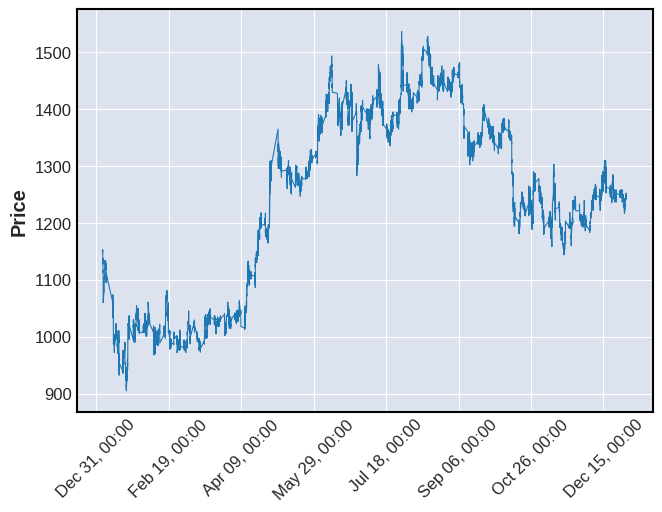

In [8]:
mpf.plot(ohlc, type="line", show_nontrading=True)

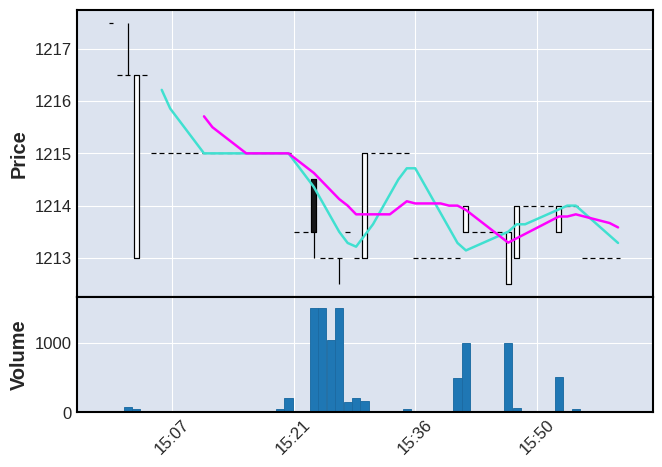

In [9]:
# Select one day of trading
day = ohlc.loc["2016-12-06 15:00":"2016-12-06 16:00", :]

# Plot candlestick chart with volume and 7 and 12 min moving averages
mpf.plot(day, type="candle", mav=(7, 12), volume=True, show_nontrading=True)

Drop temporal columns that won't be needed for observations.

In [10]:
data.drop(columns=["date", "time"], inplace=True)
data.head(1)

,open,high,low,close,volume
0,1148.9,1148.9,1148.9,1148.9,0


Filter out bars with too small changes compared to the open price.

In [11]:
data.query(
    "abs(high - open) >= 1e-8 or "
    "abs(low - open) >= 1e-8 or "
    "abs(close - open) >= 1e-8",
    inplace=True,
)
data.reset_index(drop=True, inplace=True)
data.head()

,open,high,low,close,volume
0,1156.9,1157.9,1153.0,1153.0,43
1,1150.6,1150.6,1150.4,1150.4,5
2,1150.2,1150.2,1149.5,1149.7,165
3,1149.9,1150.0,1149.9,1150.0,10
4,1150.0,1150.8,1150.0,1150.8,4


Convert prices to relative in respect to open price. This will help the model to focus on patterns like "the price has dropped by 5%" rather than on absolute values.

The drawback is that markets sometimes bounce around known turning points but we can disregard that in our example.

In [12]:
data.eval(
    """
    high = (high - open) / open
    low = (low - open) / open
    close = (close - open) / open
    """,
    inplace=True,
)
data.head()

,open,high,low,close,volume
0,1156.9,0.000864,-0.003371,-0.003371,43
1,1150.6,0.000000,-0.000174,-0.000174,5
2,1150.2,0.000000,-0.000609,-0.000435,165
3,1149.9,0.000087,0.000000,0.000087,10
4,1150.0,0.000696,0.000000,0.000696,4


Convert all the values to single precision.

In [13]:
data = data.astype(dtype=np.float32, copy=False)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31790 entries, 0 to 31789
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    31790 non-null  float32
 1   high    31790 non-null  float32
 2   low     31790 non-null  float32
 3   close   31790 non-null  float32
 4   volume  31790 non-null  float32
dtypes: float32(5)
memory usage: 621.0 KB


In [14]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
open,31790.0,1211.003174,160.147263,905.299988,1032.500000,1234.500000,1349.000000,1536.500000
high,31790.0,0.000793,0.001362,0.000000,0.000000,0.000387,0.001069,0.068702
low,31790.0,-0.000840,0.001381,-0.041529,-0.001148,-0.000393,0.000000,0.000000
close,31790.0,-0.000024,0.001804,-0.024608,-0.000805,0.000000,0.000791,0.041985
volume,31790.0,397.227692,886.181152,2.000000,47.000000,121.000000,388.000000,28983.000000


## Data Preprocessing

Wrap all preprocessing steps into a function.

In [15]:
def load_df(csv_file: str, eps: float = 1e-8) -> pd.DataFrame:
    """
    Loads CSV stocks file and pre-processes it to a DF.
    """

    # Load CSV
    df = pd.read_csv(csv_file)

    # Rename columns
    df.rename(columns=lambda c: c.strip("<>").lower(), inplace=True)
    df.rename(columns={"vol": "volume"}, inplace=True)

    # Drop irrelevant columns
    df.drop(columns=["date", "time"], inplace=True)

    # Keep bars with significant changes only
    df.query(
        f"abs(high - open) >= {eps} or "
        f"abs(low - open) >= {eps} or "
        f"abs(close - open) >= {eps}",
        inplace=True,
    )
    df.reset_index(drop=True, inplace=True)

    # Make high, low and close relative to open price
    df.eval(
        """
        high = (high - open) / open
        low = (low - open) / open
        close = (close - open) / open
        """,
        inplace=True,
    )

    # Return dataset in single precision
    return df.astype(dtype=np.float32, copy=False)


# Load both datasets as Pandas DFs
data_valid = load_df(os.path.join("data", "stocks", "YNDX_150101_151231.csv"))
data_train = load_df(os.path.join("data", "stocks", "YNDX_160101_161231.csv"))

## The Environment

### Actions

In [16]:
class Action(IntEnum):
    SKIP = 0
    BUY = 1
    CLOSE = 2

### State & Observations

In [20]:
def absolute_price(relative: float, relative_to: float) -> float:
    return 100.0 * (relative / relative_to - 1.0)


class State:
    _prices: pd.DataFrame
    offset: int
    have_position: bool
    open_price: float

    def __init__(
        self,
        n_bars: int,
        commission: float,
        reset_on_close: bool,
        reward_on_close: bool = True,
        volumes: bool = True,
        conv: bool = False,
    ) -> None:
        assert n_bars > 0
        assert commission >= 0.0

        self.n_bars = n_bars
        self.commission = commission
        self.reset_on_close = reset_on_close
        self.reward_on_close = reward_on_close
        self.conv = conv

        self._features = (
            ["high", "low", "close", "volume"]
            if volumes
            else ["high", "low", "close"]
        )

        n_features = len(self._features)

        # The shape is either 1D or 2D if convolution is enabled
        #  - The no. features is 3 or 4 (high + low + closed [+ volume])
        #  - There are 2 extra features: position flag and relative profit
        self.shape = (
            (n_features + 2, n_bars) if conv else (n_features * n_bars + 2,)
        )

    def reset(self, prices: pd.DataFrame, offset: int) -> np.ndarray:
        assert offset >= self.n_bars - 1
        self.have_position = False
        self.open_price = 0.0
        self.offset = offset
        self._prices = prices
        return self._observe()

    @property
    def close_price(self) -> float:
        """Absolute close price for the current bar"""
        op, rel_cp = self._prices.loc[self.offset, ["open", "close"]]
        return op * (1.0 + rel_cp)

    def _observe(self) -> np.ndarray:
        """Encode current state into an observation"""

        obs = np.zeros(shape=self.shape, dtype=np.float32)

        # Set relevant slice of HLC(V) bar features to the observation
        #  - Note: pd indexing is inclusive, therefore stop = offset (not + 1)

        start = self.offset - (self.n_bars - 1)
        stop = self.offset
        features = self._prices.loc[start:stop, self._features]

        obs[:-2] = features.T if self.conv else features.to_numpy().flat

        # Set last last two features if BUY action has been issued (othewise 0)
        #  1. flag indicating open position
        #  2. current close price relative to open price
        if self.have_position:
            obs[-2] = 1.0
            obs[-1] = self.close_price / self.open_price - 1.0

        return obs

    def step(self, action: Action) -> Tuple[np.ndarray, float, bool]:

        # Default outcome after this step
        done = self.offset + 1 >= len(self._prices) - 1
        reward = 0.0

        # Absolute close price for the current bar
        close = self.close_price

        if action is Action.BUY and not self.have_position:

            # Count in market commission %
            reward -= self.commission

            # Open position on bought stocks
            self.have_position = True
            self.open_price = close

        elif action is Action.CLOSE and self.have_position:

            # Mark done regardless of the state if reset on CLOSE is enabled
            done |= self.reset_on_close

            # Count in market commission %
            reward -= self.commission

            if self.reward_on_close:
                # Count in total profit of the closed position
                reward += absolute_price(close, relative_to=self.open_price)

            # Close position on bought stocks
            self.have_position = False
            self.open_price = 0.0

        # Move to the next price bar
        self.offset += 1

        if self.have_position and not self.reward_on_close:
            # Count in fraction of the profit after this step
            #  - Note: `close` is now old price before the offset shift
            reward += absolute_price(self.close_price, relative_to=close)

        return self._observe(), reward, done

### Gym Environment

In [21]:
Step = Tuple[np.ndarray, float, bool, Dict[str, Any]]


class StocksEnv(gym.Env):
    metadata = {"render.modes": ["human"]}
    spec = EnvSpec("StocksEnv-v0")

    def __init__(
        self,
        prices: Mapping[str, pd.DataFrame],
        n_bars: int = 10,
        commission: float = 0.1,
        reset_on_close: bool = True,
        conv: bool = False,
        random_offset_on_reset: bool = True,
        reward_on_close: bool = False,
        volumes: bool = False,
    ) -> None:
        self._prices = prices

        self._state = State(
            n_bars=n_bars,
            commission=commission,
            reset_on_close=reset_on_close,
            reward_on_close=reward_on_close,
            volumes=volumes,
            conv=conv,
        )

        self.action_space = gym.spaces.Discrete(n=len(Action))
        self.observation_space = gym.spaces.Box(
            low=-np.inf,
            high=np.inf,
            shape=self._state.shape,
            dtype=np.float32,
        )

        self.random_offset_on_reset = random_offset_on_reset
        self.seed()

    def reset(self) -> np.ndarray:
        # Make selection of the instrument and it's offset, then reset the state
        self._instrument = self.np_random.choice(list(self._prices.keys()))
        prices = self._prices[self._instrument]
        n_bars = self._state.n_bars
        offset = (
            self.np_random.choice(len(prices) - n_bars * 10) + n_bars
            if self.random_offset_on_reset
            else n_bars
        )
        return self._state.reset(prices, offset)

    def step(self, action: Action) -> Step:
        obs, reward, done = self._state.step(action)
        info = {
            "instrument": self._instrument,
            "offset": self._state.offset,
        }
        return obs, reward, done, info

    def render(self, mode: str = "human", close: bool = False) -> Any:
        raise NotImplementedError

    def close(self) -> None:
        raise NotImplementedError

    def seed(self, seed: Optional[int] = None) -> Tuple[int, int]:
        self.np_random, seed1 = seeding.np_random(seed)
        seed2 = seeding.hash_seed(seed1 + 1) % 2 ** 31
        return [seed1, seed2]

    @classmethod
    def from_dir(cls, data_dir: str, **kwargs: Any) -> "StocksEnv":
        prices = {
            file_path: load_df(file_path)
            for file_path in glob.glob(os.path.join(data_dir, "*.csv"))
        }
        return StocksEnv(prices, **kwargs)

### Test Environment & State

In [22]:
def some_prices() -> pd.DataFrame:
    df = pd.DataFrame.from_dict(
        {
            "open": pd.Series([1.0, 2.0, 3.0, 1.0]),
            "high": pd.Series([2.0, 3.0, 4.0, 2.0]),
            "low": pd.Series([0.0, 1.0, 2.0, 0.0]),
            "close": pd.Series([2.0, 3.0, 1.0, 2.0]),
            "volume": pd.Series([10.0, 10.0, 10.0, 10.0]),
        }
    )
    df.eval(
        """
        high = (high - open) / open
        low = (low - open) / open
        close = (close - open) / open
        """,
        inplace=True,
    )
    return df.astype(dtype=np.float32, copy=False)


def test_state_basic() -> None:
    s = State(n_bars=4, commission=0.0, reset_on_close=False, volumes=False)
    assert s.shape == (4 * 3 + 2,)


def test_state_reset() -> None:
    s = State(
        n_bars=1,
        commission=0.0,
        reset_on_close=False,
        reward_on_close=True,
    )

    _ = s.reset(prices=some_prices(), offset=0)
    assert not s.have_position
    assert math.isclose(s.close_price, 2.0)

    _, reward, done = s.step(Action.SKIP)
    assert not done
    assert math.isclose(reward, 0.0)
    assert math.isclose(s.close_price, 3.0)

    _, reward, done = s.step(Action.SKIP)
    assert not done
    assert math.isclose(reward, 0.0)
    assert math.isclose(s.close_price, 1.0, rel_tol=1e-7)

    _, reward, done = s.step(Action.SKIP)
    assert done
    assert math.isclose(reward, 0.0)
    assert math.isclose(s.close_price, 2.0)


def test_state_commission() -> None:
    s = State(n_bars=1, commission=1.0, reset_on_close=False)

    _ = s.reset(prices=some_prices(), offset=0)
    assert not s.have_position
    assert math.isclose(s.close_price, 2.0)

    _, reward, done = s.step(Action.BUY)
    assert not done
    assert s.have_position

    # Execution price is the cur bar close, comission 1%, reward in percent
    expected = 100.0 * (3.0 - 2.0) / 2.0 - 1.0
    assert math.isclose(reward, expected), f"{reward} != {expected}"
    assert math.isclose(s.close_price, 3.0)


def test_state_final_reward() -> None:
    s = State(
        n_bars=1,
        commission=0.0,
        reset_on_close=False,
        reward_on_close=True,
    )

    _ = s.reset(prices=some_prices(), offset=0)
    assert not s.have_position
    assert math.isclose(s.close_price, 2.0)

    _, reward, done = s.step(Action.BUY)
    assert s.have_position
    assert not done
    assert math.isclose(reward, 50.0), f"{reward} != 50.0"
    assert math.isclose(s.close_price, 3.0)

    _, reward, done = s.step(Action.SKIP)
    assert not done
    assert math.isclose(
        reward, -2 / 3 * 100.0, rel_tol=1e-7
    ), f"{reward} != {-2 / 3 * 100.0}"
    assert math.isclose(s.close_price, 1.0, rel_tol=1e-7), f"{s.close_price}"

    _, reward, done = s.step(Action.CLOSE)
    assert done
    assert math.isclose(reward, -50.0), f"{reward} != -50.0"
    assert math.isclose(s.close_price, 2.0)


def test_conv_state_basic() -> None:
    s = State(
        n_bars=2,
        commission=0.0,
        reset_on_close=False,
        volumes=True,
        conv=True,
    )
    assert s.shape == (6, 2)
    obs = s.reset(prices=some_prices(), offset=1)
    assert s.shape == obs.shape


def test_env_simple() -> None:
    prices = load_df(os.path.join("data", "stocks", "YNDX_160101_161231.csv"))
    env = StocksEnv({"YNDX": prices})
    _ = env.reset()
    _, reward, _, _ = env.step(Action.SKIP)
    assert math.isclose(reward, 0.0), "reward != 0.0"


# Run all tests
test_state_basic()
test_state_reset()
test_state_commission()
test_state_final_reward()
test_conv_state_basic()
test_env_simple()

AssertionError: -1.0 != 49.0